Zaimportowanie bibliotek potrzebnych do rysowania grafów sieci.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
def gen_graph():
    graph = nx.Graph()
    graph.add_nodes_from([i for i in range(1,21)])
    for i in range(1,20):
        graph.add_edge(i,i+1)
    # dodanie dodatkowych 5 losowych krawędzi
    for _ in range(5):
        i = random.randint(1,20)
        k = i
        while k == i:
            k = random.randint(1,20)
        graph.add_edge(i,k)
    nx.draw(graph, with_labels=True)
    plt.show()
    N = gen_intensity_matrix(graph, 50, 200)
    return graph,N

In [3]:
def gen_intensity_matrix(graph, low, high):
    """
    argumenty low i high są odpowiednio dolnym i górnym ograniczeniem
    przedziału, z którego losuję wartości natężeń
    """
    size = graph.number_of_nodes()
    N = np.zeros((size,size)) 
    for i in range(size):
        for j in range(size):
            if i == j:
                N[i][j] = 0
            else:
                N[i][j] = random.randint(low,high)
    return N

Niech funkcja przepustowości c będzie stała dla wszystkich krawędzi i równa 16384 bitów

Niech funkcja przepływu a dla wierzchołków i,j będzie zdefiniowana jako suma natężen na najkrótszej ścieżce z wierzchołka i do wierzchołka j

In [4]:
def set_a_function(graph, intensity_matrix):
    size = graph.number_of_nodes()

    for i, row in enumerate(intensity_matrix,1):
        for j, intensity in enumerate(row,1):
            if i != j:
                path = nx.shortest_path(graph, i, j)
                for p in range(len(path)-1):
                    graph[path[p]][path[p+1]]['a'] += intensity
                


In [21]:
def set_c_function(graph, intensity_matrix, range):
    """ zmienna range to para liczb ograniczających przedział"""
    size = graph.number_of_nodes()
    avg_intensity = np.sum(intensity_matrix) // (size*size-size)
    if CAPACITY == 0:
        for e in graph.edges():
            multiplier = random.randint(range[0], range[1])
            graph[e[0]][e[1]]['c'] = avg_intensity*multiplier
    else:
        nx.set_edge_attributes(graph, CAPACITY, 'c')

In [6]:
def delay(graph, intensity_matrix, average_packet_size):
    G = np.sum(intensity_matrix)
    m = average_packet_size
    sum_e = 0
    for e in graph.edges():
        a = graph.get_edge_data(*e).get('a')
        c = graph.get_edge_data(*e).get('c')
        sum_e += a/(c/m - a)
  
    return sum_e/G

In [7]:
def check_capacity(g):
    for e in g.edges():
        if g.get_edge_data(*e).get('a') > g.get_edge_data(*e).get('c'):
            return False
    return True

In [8]:
def is_working(p, graph, N, avg_packet_size, capacity_range):
    nx.set_edge_attributes(graph, p, 'p')
    delays = []
    for _ in range(1000):
        g = nx.Graph(graph)
        for e in g.edges():
            if g.get_edge_data(*e).get('p') < random.random():
                g.remove_edge(*e)

        if not nx.is_connected(g):
            continue

        set_a_function(g, N)
        set_c_function(g, N, capacity_range)

        if not check_capacity(g):
            continue

        delays.append(delay(g, N, avg_packet_size))

    return delays

In [9]:
def reliability(N, p, T_max, graph, avg_packet_size, capacity_range):
    """
    p - prawdopodobieństwo nie uszkodzenia krawędzi
    avg_packet_size - średni rozmiar pakietu czyli wartość m
    capacity_range - zakres, z którego będzie wybierany mnożnik do ustalenia przepustowości
    """
    delays = is_working(p, graph, N, avg_packet_size, capacity_range)

    if len(delays) != 0:
        connected_num = len(delays)/1000
        avg_delay = sum(delays)/len(delays)

        good_T_num = 0
        for d in delays:
            if d < T_max:
                good_T_num += 1
    else: 
        connected_num = 0
        avg_delay = 0
        good_T_num = 0

    return connected_num, avg_delay, (good_T_num/1000)


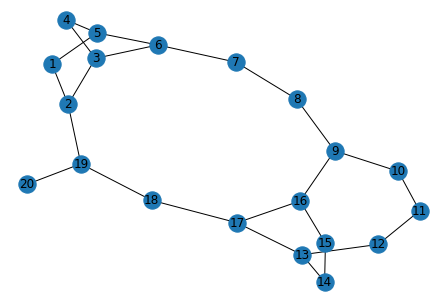

In [11]:
graph, N = gen_graph()

In [12]:
nx.set_edge_attributes(graph, 0, 'a')
nx.set_edge_attributes(graph, 0, 'c')
avg_packet_size = 1
capacity_range = (400,600)
connected_num, avg_del, reli_chance = reliability(N, 0.95, 0.0001, graph, avg_packet_size, capacity_range)
print("Chance of network working properly: ", connected_num)
print("Average delay:%6.6f " % avg_del)
print("Reliability: ", reli_chance)

Chance of network working properly:  0.886
Average delay:0.000081 
Reliability:  0.756


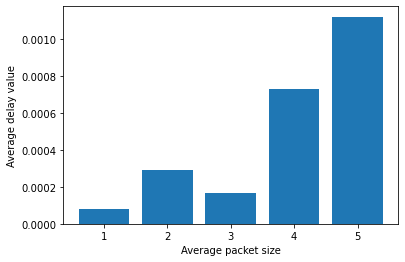

In [14]:
def f(avg_packet_size):
    connected_num, avg_del, reli_chance = reliability(N, 0.95, 0.0002, graph, avg_packet_size, (capacity_range))

    return avg_del

def packet_size_to_average_delay_plot():
    avg_packet_size = [i for i in range(1,6)]
    avg_del = [f(d) for d in avg_packet_size]
    plt.bar(np.arange(len(avg_packet_size)), avg_del, align='center')
    plt.xticks(np.arange(len(avg_packet_size)), avg_packet_size)
    plt.xlabel("Average packet size")
    plt.ylabel("Average delay value")

    plt.show()

packet_size_to_average_delay_plot()

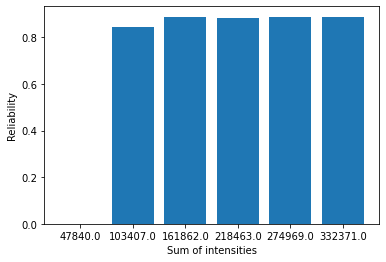

In [36]:
def f(N):
    connected_num, avg_del, reli_chance = reliability(N, 0.95, 0.00005, graph, 1, (400,600))

    return reli_chance

def inc_N_reli(graph):

    intensity_arr = [gen_intensity_matrix(graph, 50+i*30,200+i*30) for i in range(0,30,5)]
    intensity_sum_arr = [np.sum(i) for i in intensity_arr]
    reli_arr = [f(x) for x in intensity_arr]
    plt.bar(np.arange(len(intensity_arr)),reli_arr, align='center')
    plt.xticks(np.arange(len(intensity_arr)), intensity_sum_arr)
    plt.xlabel("Sum of intensities")
    plt.ylabel("Reliability")
    
    plt.show()
CAPACITY = 0
inc_N_reli(graph)

[(300, 500), (375, 575), (450, 650), (525, 725), (600, 800)]


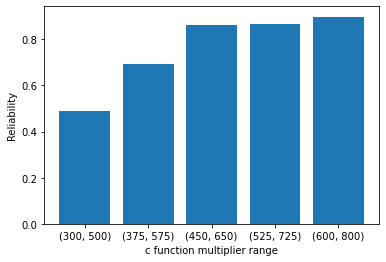

In [41]:
def f(cap_range):
    connected_num, avg_del, reli_chance = reliability(N, 0.95, 0.0001, graph, 1, cap_range)

    return reli_chance

def inc_c_reli(graph):
    c_arr = [(300+i*75,500+i*75) for i in range(5)] # TODO zrobić tego capacity i to oddać w końcu ide spać 
    print(c_arr)
    # c_arr = [70000+i*5000 for i in range(5)]
    reli_arr = [f(cap_range) for cap_range in c_arr]


    plt.bar(np.arange(len(c_arr)), reli_arr, align='center')
    plt.xticks(np.arange(len(c_arr)), c_arr)
    plt.xlabel("c function multiplier range")
    plt.ylabel("Reliability")
    
    plt.show()

inc_c_reli(graph)

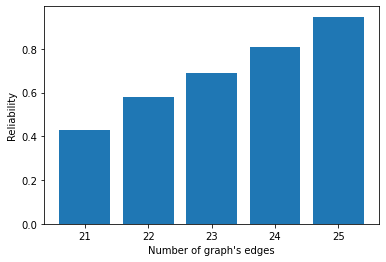

In [61]:
def f(g):
    N = gen_intensity_matrix(g, 50, 200)
    connected_num, avg_del, reli_chance = reliability(N, 0.95, 0.0001, g, 1, (400,600))

    return reli_chance

def add_edge_reli(graph):
    g = nx.Graph(graph)
    
    reli_arr = []
    num_edges = []
    in_num_edges = g.number_of_edges()

    for i in range(5):
        nx.set_edge_attributes(g, 0, 'c')
        nx.set_edge_attributes(g, 0, 'a')
        reli_arr.append(f(g))

        j = random.randint(1,20)
        k = j
        while j == k or (j,k) in g.edges() or (k,j) in g.edges():
            k = random.randint(1,20)

        num_edges.append(in_num_edges+i)
        g.add_edge(j,k)

    plt.bar(np.arange(len(num_edges)), reli_arr, align='center')
    plt.xticks(np.arange(len(num_edges)), num_edges)
    plt.xlabel("Number of graph's edges")
    plt.ylabel("Reliability")
    

add_edge_reli(graph)